In [4]:
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## 0. Load Data

In [5]:
import pandas as pd

# Specify the file path
file_path = 'data.txt'

# Read data from the text file into a pandas DataFrame
df = pd.read_csv(file_path)  

# Print or use the resulting DataFrame
df.head(10)

,date,avaliable,occupied,unknown,hour,minute,day_of_week
0,202010010000,1,11,0,0,0,3
1,202010010001,1,11,0,0,1,3
2,202010010002,1,11,0,0,2,3
3,202010010003,1,11,0,0,3,3
4,202010010004,1,11,0,0,4,3
5,202010010005,1,11,0,0,5,3
6,202010010006,1,11,0,0,6,3
7,202010010007,1,11,0,0,7,3
8,202010010008,1,11,0,0,8,3
9,202010010009,1,11,0,0,9,3


In [6]:
df['timestamp'] = pd.to_datetime(df['date'],format='%Y%m%d%H%M')
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['day_of_week'] = df['timestamp'].dt.dayofweek

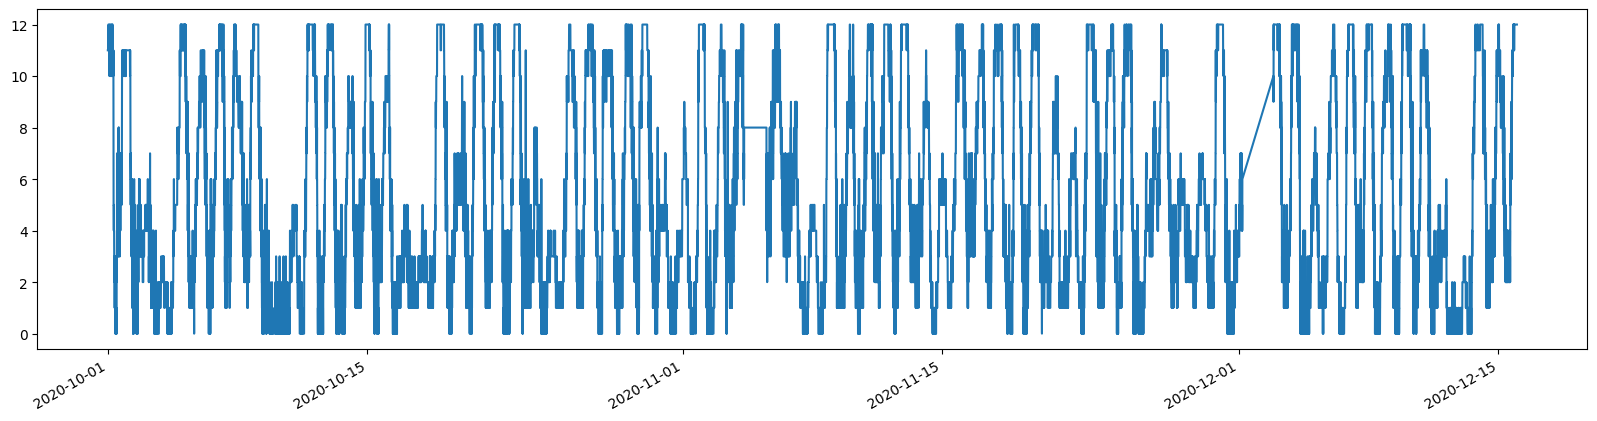

In [7]:
fig2, ax2 = plt.subplots(figsize=(20,5))
ax2.plot(df['timestamp'],df['occupied'], label='Value')
fig2.autofmt_xdate()

In [69]:
final_df = df[['timestamp','occupied','hour','minute','day_of_week']]
final_df = final_df.set_index('timestamp')
final_df

,occupied,hour,minute,day_of_week
timestamp,,,,
2020-10-01 00:00:00,11,0,0,3
2020-10-01 00:01:00,11,0,1,3
2020-10-01 00:02:00,11,0,2,3
2020-10-01 00:03:00,11,0,3,3
2020-10-01 00:04:00,11,0,4,3
...,...,...,...,...
2020-12-15 23:55:00,12,23,55,1
2020-12-15 23:56:00,12,23,56,1
2020-12-15 23:57:00,12,23,57,1


## 1. LSTM Data Preparation

In [70]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [107]:
# load dataset
dataset = final_df
values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed2 = series_to_supervised(scaled, 1, 1)

print(reframed2.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)  var2(t)   var3(t)  \
1   0.916667        0.0   0.000000        0.5  0.916667      0.0  0.016949   
2   0.916667        0.0   0.016949        0.5  0.916667      0.0  0.033898   
3   0.916667        0.0   0.033898        0.5  0.916667      0.0  0.050847   
4   0.916667        0.0   0.050847        0.5  0.916667      0.0  0.067797   
5   0.916667        0.0   0.067797        0.5  0.916667      0.0  0.084746   

   var4(t)  
1      0.5  
2      0.5  
3      0.5  
4      0.5  
5      0.5  


## 2. Define and Fit Model

In [85]:
import numpy as np

# split into train and test sets
values = reframed2.values

# train 70%, test 30%
train_index = int(np.floor(len(reframed2) * 0.7))

train = values[:train_index, :]
test = values[train_index:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(74882, 1, 7) (74882,) (32093, 1, 7) (32093,)


Epoch 1/50
1041/1041 - 4s - loss: 0.1194 - val_loss: 0.0740 - 4s/epoch - 4ms/step
Epoch 2/50
1041/1041 - 2s - loss: 0.0270 - val_loss: 0.0405 - 2s/epoch - 2ms/step
Epoch 3/50
1041/1041 - 2s - loss: 0.0197 - val_loss: 0.0244 - 2s/epoch - 2ms/step
Epoch 4/50
1041/1041 - 2s - loss: 0.0154 - val_loss: 0.0162 - 2s/epoch - 2ms/step
Epoch 5/50
1041/1041 - 2s - loss: 0.0131 - val_loss: 0.0183 - 2s/epoch - 2ms/step
Epoch 6/50
1041/1041 - 2s - loss: 0.0118 - val_loss: 0.0242 - 2s/epoch - 2ms/step
Epoch 7/50
1041/1041 - 2s - loss: 0.0172 - val_loss: 0.0307 - 2s/epoch - 2ms/step
Epoch 8/50
1041/1041 - 2s - loss: 0.0157 - val_loss: 0.0254 - 2s/epoch - 2ms/step
Epoch 9/50
1041/1041 - 2s - loss: 0.0154 - val_loss: 0.0186 - 2s/epoch - 2ms/step
Epoch 10/50
1041/1041 - 2s - loss: 0.0146 - val_loss: 0.0235 - 2s/epoch - 2ms/step
Epoch 11/50
1041/1041 - 2s - loss: 0.0138 - val_loss: 0.0282 - 2s/epoch - 2ms/step
Epoch 12/50
1041/1041 - 2s - loss: 0.0125 - val_loss: 0.0173 - 2s/epoch - 2ms/step
Epoch 13/50
1

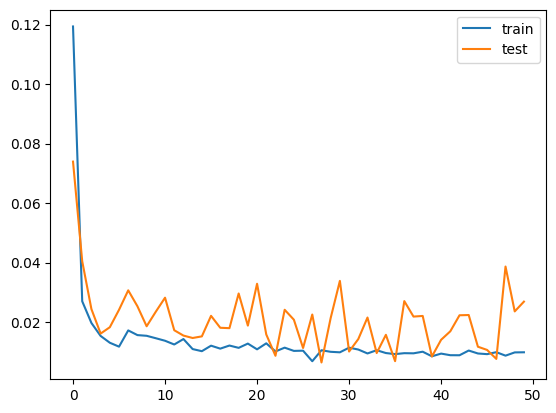

In [73]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [91]:
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0]*test_X.shape[1], test_X.shape[2]))

1003/1003 [==============================] - 1s 969us/step


In [99]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


ValueError: operands could not be broadcast together with shapes (32093,7) (4,) (32093,7) 

## 3. Visualization

In [120]:
vis = pd.DataFrame({'predict': pd.Series(yhat.flatten()), 'truth': test_y,'timestamp':final_df.index[-32093:]})

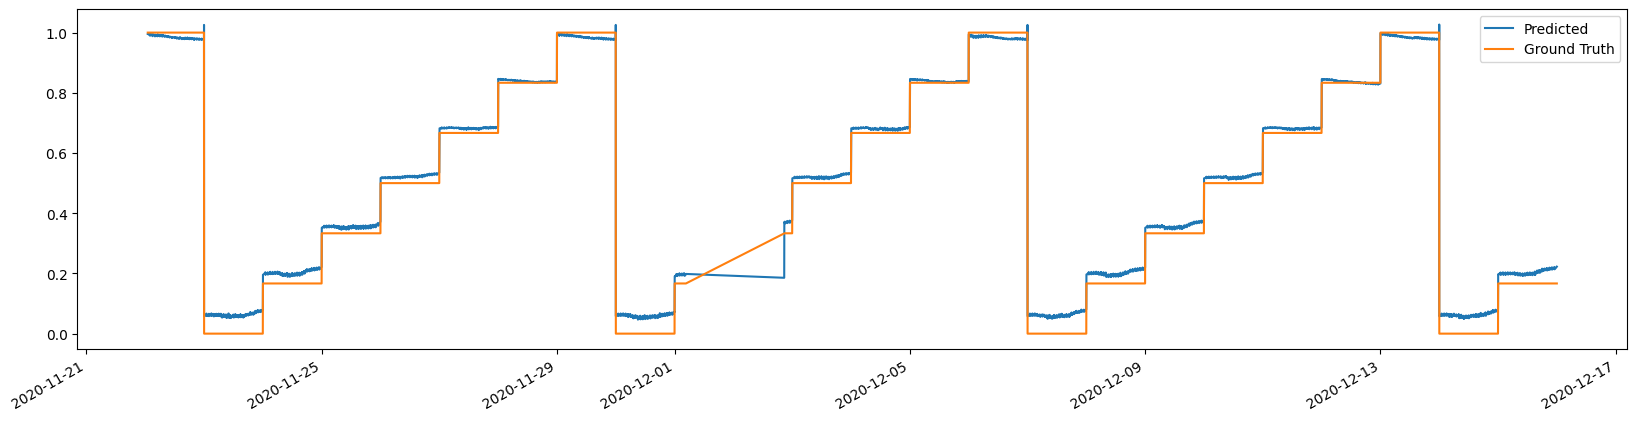

In [126]:
fig3, ax3 = plt.subplots(figsize=(20,5))
ax3.plot(vis['timestamp'],vis['predict'], label='Predicted')
ax3.plot(vis['timestamp'],vis['truth'], label='Ground Truth')
ax3.legend()
fig3.autofmt_xdate()

In [129]:
# Show weekly to see if makes sense?

,occupied,hour,minute,day_of_week
timestamp,,,,
2020-12-15 23:50:00,12,23,50,1
2020-12-15 23:51:00,12,23,51,1
2020-12-15 23:52:00,12,23,52,1
2020-12-15 23:53:00,12,23,53,1
2020-12-15 23:54:00,12,23,54,1
2020-12-15 23:55:00,12,23,55,1
2020-12-15 23:56:00,12,23,56,1
2020-12-15 23:57:00,12,23,57,1
2020-12-15 23:58:00,12,23,58,1
